In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [3]:
#static parameters
train_batch_size = 60
val_batch_size = 60
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [17]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [18]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [19]:
#network_output

In [20]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


C:\Users\utkar\Anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
C:\Users\utkar\Anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


,values
0,
0,2
1,3
2,7
3,2
4,24
5,3
6,21
7,4
8,39


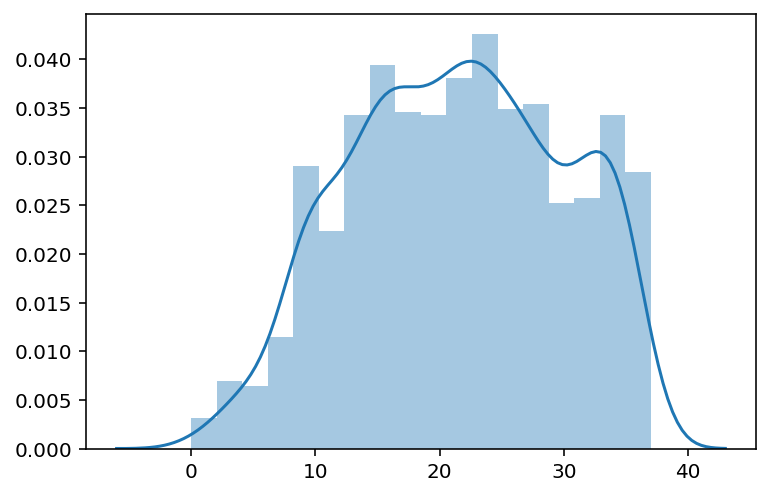

In [21]:
'''
data is highly unbalanced
# '''
sns.distplot(torch.tensor(network_output).cpu())
xx = pd.DataFrame(torch.tensor(network_output).cpu())
xx.groupby(0).size().to_frame(name='values')

In [22]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -29]
network_output = network_output[: -29]

print(network_input.shape)
print(network_output.shape)

torch.Size([1800, 50, 1])
torch.Size([1800])


In [23]:
#network_input[0]

In [24]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size, num_layers = 1, batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, hidden1, hidden2,batch_size):
        
        output, hidden1 = self.lstm1(x, hidden1)        
        #print(output.shape)
        
        output = self.dropout(output)
        
        output, hidden2 = self.lstm2(output, hidden2)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden2
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(1, batch_size, self.hidden_size).zero_().cuda(),
          weight.new(1, batch_size, self.hidden_size).zero_().cuda())
        
        hidden2 = (weight.new(1, batch_size, 38).zero_().cuda(),
          weight.new(1, batch_size, 38).zero_().cuda())
        return hidden1,hidden2

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [25]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [26]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [27]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [28]:
#hidden = model.hidden_init(train_batch_size) 
#hidden

In [29]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden1, hidden2 = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        #h = tuple([each.data for each in hidden])
        h1 = tuple([each.data for each in hidden1])
        h2 = tuple([each.data for each in hidden2])
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, h = model.forward(inputs, h1, h2, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        #logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h1 = tuple([each.data for each in hidden1])
        val_h2 = tuple([each.data for each in hidden2])
        
        output, hidden = model.forward(inputs, val_h1, val_h2,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256_different_layers.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.6161777 	Val Loss:3.4479937 	Train Acc: 4.097222% 	Val Acc: 9.7222225%
Validation Loss decreased from    inf to 3.447994, saving the model weights
Epoch: 1	Train Loss: 3.5096459 	Val Loss:3.2864229 	Train Acc: 3.541667% 	Val Acc: 9.7222225%
Validation Loss decreased from 3.447994 to 3.286423, saving the model weights
Epoch: 2	Train Loss: 3.4104355 	Val Loss:3.2137272 	Train Acc: 4.652778% 	Val Acc: 8.8888891%
Validation Loss decreased from 3.286423 to 3.213727, saving the model weights
Epoch: 3	Train Loss: 3.3818594 	Val Loss:3.1788160 	Train Acc: 3.680556% 	Val Acc: 8.8888891%
Validation Loss decreased from 3.213727 to 3.178816, saving the model weights
Epoch: 4	Train Loss: 3.3538115 	Val Loss:3.1596198 	Train Acc: 4.027778% 	Val Acc: 8.8888891%
Validation Loss decreased from 3.178816 to 3.159620, saving the model weights
Epoch: 5	Train Loss: 3.3428827 	Val Loss:3.1475785 	Train Acc: 5.208333% 	Val Acc: 8.8888891%
Validation Loss decreased from 3.159620 to 3.147

Epoch: 56	Train Loss: 2.6812657 	Val Loss:2.5753951 	Train Acc: 17.91667% 	Val Acc: 13.3333335%
Epoch: 57	Train Loss: 2.6644335 	Val Loss:2.5314693 	Train Acc: 17.22222% 	Val Acc: 17.7777782%
Epoch: 58	Train Loss: 2.6624126 	Val Loss:2.4953632 	Train Acc: 17.01389% 	Val Acc: 22.2222224%
Epoch: 59	Train Loss: 2.6483391 	Val Loss:2.5068866 	Train Acc: 17.15278% 	Val Acc: 19.4444450%
Epoch: 60	Train Loss: 2.6529973 	Val Loss:2.5143514 	Train Acc: 15.76389% 	Val Acc: 18.6111116%
Epoch: 61	Train Loss: 2.6688503 	Val Loss:2.5158737 	Train Acc: 14.86111% 	Val Acc: 18.8888891%
Epoch: 62	Train Loss: 2.6310066 	Val Loss:2.4816039 	Train Acc: 16.80556% 	Val Acc: 19.7222225%
Validation Loss decreased from 2.484204 to 2.481604, saving the model weights
Epoch: 63	Train Loss: 2.6351730 	Val Loss:2.4977857 	Train Acc: 16.31944% 	Val Acc: 20.5555558%
Epoch: 64	Train Loss: 2.6262901 	Val Loss:2.5349903 	Train Acc: 17.98611% 	Val Acc: 17.2222226%
Epoch: 65	Train Loss: 2.6284908 	Val Loss:2.5441226 	Train

Epoch: 121	Train Loss: 2.1507950 	Val Loss:1.8322873 	Train Acc: 32.22222% 	Val Acc: 43.0555557%
Validation Loss decreased from 1.848474 to 1.832287, saving the model weights
Epoch: 122	Train Loss: 2.1582946 	Val Loss:1.8974942 	Train Acc: 30.97222% 	Val Acc: 41.9444447%
Epoch: 123	Train Loss: 2.1439714 	Val Loss:1.8430928 	Train Acc: 31.11111% 	Val Acc: 41.9444447%
Epoch: 124	Train Loss: 2.1218420 	Val Loss:1.8356796 	Train Acc: 32.56944% 	Val Acc: 44.1666668%
Epoch: 125	Train Loss: 2.1202245 	Val Loss:1.8393978 	Train Acc: 31.04167% 	Val Acc: 40.8333331%
Epoch: 126	Train Loss: 2.0956503 	Val Loss:1.7726351 	Train Acc: 32.56944% 	Val Acc: 45.2777778%
Validation Loss decreased from 1.832287 to 1.772635, saving the model weights
Epoch: 127	Train Loss: 2.0960314 	Val Loss:1.7943544 	Train Acc: 33.95833% 	Val Acc: 44.4444438%
Epoch: 128	Train Loss: 2.1141382 	Val Loss:1.8389186 	Train Acc: 32.29167% 	Val Acc: 41.9444442%
Epoch: 129	Train Loss: 2.1047068 	Val Loss:1.7954662 	Train Acc: 33.

Epoch: 186	Train Loss: 1.6737133 	Val Loss:1.2427095 	Train Acc: 45.48611% 	Val Acc: 66.3888892%
Epoch: 187	Train Loss: 1.6865737 	Val Loss:1.2599642 	Train Acc: 44.30556% 	Val Acc: 63.3333330%
Epoch: 188	Train Loss: 1.5942107 	Val Loss:1.2349796 	Train Acc: 48.68056% 	Val Acc: 63.0555555%
Epoch: 189	Train Loss: 1.5484352 	Val Loss:1.1869032 	Train Acc: 49.72222% 	Val Acc: 69.7222213%
Validation Loss decreased from 1.232874 to 1.186903, saving the model weights
Epoch: 190	Train Loss: 1.5301210 	Val Loss:1.1386236 	Train Acc: 51.45833% 	Val Acc: 69.1666673%
Validation Loss decreased from 1.186903 to 1.138624, saving the model weights
Epoch: 191	Train Loss: 1.4794559 	Val Loss:1.1348720 	Train Acc: 52.98611% 	Val Acc: 70.8333333%
Validation Loss decreased from 1.138624 to 1.134872, saving the model weights
Epoch: 192	Train Loss: 1.4452928 	Val Loss:1.1225703 	Train Acc: 53.47222% 	Val Acc: 68.0555552%
Validation Loss decreased from 1.134872 to 1.122570, saving the model weights
Epoch: 19

Epoch: 247	Train Loss: 0.9031240 	Val Loss:0.5340395 	Train Acc: 73.47222% 	Val Acc: 87.2222225%
Validation Loss decreased from 0.535509 to 0.534039, saving the model weights
Epoch: 248	Train Loss: 0.8670259 	Val Loss:0.5628681 	Train Acc: 74.65278% 	Val Acc: 86.9444460%
Epoch: 249	Train Loss: 0.9138094 	Val Loss:0.5201782 	Train Acc: 72.70833% 	Val Acc: 87.7777765%
Validation Loss decreased from 0.534039 to 0.520178, saving the model weights
Epoch: 250	Train Loss: 0.8801294 	Val Loss:0.5276121 	Train Acc: 72.29167% 	Val Acc: 88.6111101%
Epoch: 251	Train Loss: 0.8929895 	Val Loss:0.5146815 	Train Acc: 73.125% 	Val Acc: 88.8888886%
Validation Loss decreased from 0.520178 to 0.514681, saving the model weights
Epoch: 252	Train Loss: 0.8552054 	Val Loss:0.5163469 	Train Acc: 74.02778% 	Val Acc: 87.7777785%
Epoch: 253	Train Loss: 0.8265047 	Val Loss:0.4844210 	Train Acc: 76.73611% 	Val Acc: 89.7222221%
Validation Loss decreased from 0.514681 to 0.484421, saving the model weights
Epoch: 254	

Epoch: 310	Train Loss: 0.4609472 	Val Loss:0.1722299 	Train Acc: 87.63889% 	Val Acc: 96.6666669%
Validation Loss decreased from 0.179297 to 0.172230, saving the model weights
Epoch: 311	Train Loss: 0.4370371 	Val Loss:0.1620302 	Train Acc: 88.40278% 	Val Acc: 95.8333333%
Validation Loss decreased from 0.172230 to 0.162030, saving the model weights
Epoch: 312	Train Loss: 0.4178191 	Val Loss:0.1572766 	Train Acc: 89.16667% 	Val Acc: 96.3888884%
Validation Loss decreased from 0.162030 to 0.157277, saving the model weights
Epoch: 313	Train Loss: 0.4091134 	Val Loss:0.1572998 	Train Acc: 88.54167% 	Val Acc: 96.6666659%
Epoch: 314	Train Loss: 0.3973325 	Val Loss:0.1569738 	Train Acc: 90.34722% 	Val Acc: 96.3888884%
Validation Loss decreased from 0.157277 to 0.156974, saving the model weights
Epoch: 315	Train Loss: 0.3966141 	Val Loss:0.1558762 	Train Acc: 89.23611% 	Val Acc: 96.3888884%
Validation Loss decreased from 0.156974 to 0.155876, saving the model weights
Epoch: 316	Train Loss: 0.392

Epoch: 379	Train Loss: 0.2219430 	Val Loss:0.0614991 	Train Acc: 94.02778% 	Val Acc: 98.6111114%
Epoch: 380	Train Loss: 0.2165846 	Val Loss:0.0589016 	Train Acc: 94.93055% 	Val Acc: 98.0555554%
Validation Loss decreased from 0.058955 to 0.058902, saving the model weights
Epoch: 381	Train Loss: 0.1999811 	Val Loss:0.0603714 	Train Acc: 95.06944% 	Val Acc: 97.7777779%
Epoch: 382	Train Loss: 0.2128002 	Val Loss:0.0664045 	Train Acc: 94.44444% 	Val Acc: 97.7777779%
Epoch: 383	Train Loss: 0.2083677 	Val Loss:0.0935837 	Train Acc: 94.51389% 	Val Acc: 96.9444444%
Epoch: 384	Train Loss: 0.2175467 	Val Loss:0.0572125 	Train Acc: 95.0% 	Val Acc: 98.8888880%
Validation Loss decreased from 0.058902 to 0.057213, saving the model weights
Epoch: 385	Train Loss: 0.2021659 	Val Loss:0.0582814 	Train Acc: 95.0% 	Val Acc: 98.3333329%
Epoch: 386	Train Loss: 0.2061744 	Val Loss:0.0589535 	Train Acc: 94.375% 	Val Acc: 98.3333319%
Epoch: 387	Train Loss: 0.2045249 	Val Loss:0.0751083 	Train Acc: 95.20833% 	Va

Epoch: 458	Train Loss: 0.1716879 	Val Loss:0.0445458 	Train Acc: 95.55556% 	Val Acc: 98.6111114%
Epoch: 459	Train Loss: 0.1544534 	Val Loss:0.0486715 	Train Acc: 96.31944% 	Val Acc: 98.3333329%
Epoch: 460	Train Loss: 0.1642503 	Val Loss:0.0474413 	Train Acc: 96.18056% 	Val Acc: 98.3333329%
Epoch: 461	Train Loss: 0.1576049 	Val Loss:0.0371984 	Train Acc: 95.625% 	Val Acc: 99.1666665%
Epoch: 462	Train Loss: 0.1803226 	Val Loss:0.0490276 	Train Acc: 94.79167% 	Val Acc: 97.7777779%
Epoch: 463	Train Loss: 0.1853967 	Val Loss:0.0435055 	Train Acc: 95.13889% 	Val Acc: 98.8888880%
Epoch: 464	Train Loss: 0.1876464 	Val Loss:0.0554841 	Train Acc: 94.58333% 	Val Acc: 98.3333319%
Epoch: 465	Train Loss: 0.1857163 	Val Loss:0.0618164 	Train Acc: 95.41667% 	Val Acc: 96.6666669%
Epoch: 466	Train Loss: 0.2076410 	Val Loss:0.0542204 	Train Acc: 94.375% 	Val Acc: 97.7777769%
Epoch: 467	Train Loss: 0.2012300 	Val Loss:0.0743779 	Train Acc: 94.30556% 	Val Acc: 97.2222219%
Epoch: 468	Train Loss: 0.1650022 	

## MUSIC GENERATION

In [30]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256_different_layers.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [38]:
#load population database
#testing_data = np.ones(200)*0
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

In [39]:
#testing_data

In [40]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    h1, h2 = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
                
        test_hidden1 = tuple([each.data for each in h1])
        test_hidden2 = tuple([each.data for each in h2])
        
        test_output,_ = test_model.forward(test_slice, test_hidden1, test_hidden2, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [41]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [42]:
#predicted_notes_lst

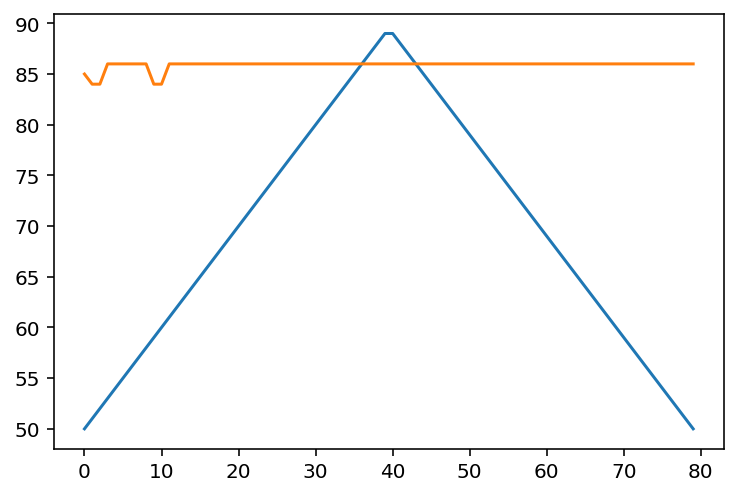

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))
#plt.plot(list(np.ones(200)*50))
plt.plot(testing_data)
plt.plot(predicted_notes_lst)

In [44]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({85: 1, 84: 4, 86: 75})